<a href="https://colab.research.google.com/github/bcataldo3/plantilla_curso_python/blob/main/docs/Clase_04 - Modelo K-Medias Caso Estudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo K-Medias - Caso Estudio
## Caso de Estudio

En este capítulo, vamos a utilizar el conocido conjunto de datos Breast Cancer Wisconsin (cáncer de mamas de Wisconsin) para realizar un análisis de conglomerados. Originalmente, el conjunto de datos se propuso con el fin de entrenar clasificadores; sin embargo, también puede ser muy útil para un análisis de conglomerados sin tener en cuenta sus etiquetas (si es un tumor benigno o maligno). Contiene 569 registros compuestos por 32 atributos (incluyendo el diagnóstico y un número de identificación). Todos los atributos están estrictamente relacionados con propiedades biológicas y morfológicas de los tumores.

Nuestro objetivo será validar hipótesis genéricas considerando la verdad fundamental (tumor benigno o maligno) y las propiedades estadísticas del conjunto de datos. Antes de continuar, es importante aclarar algunos puntos.

+ El conjunto de datos es de alta dimensionalidad y los grupos son no convexos (por lo que no podemos esperar una segmentación perfecta).

+ Nuestro objetivo no es utilizar un algoritmo de agrupamiento para obtener los resultados de un clasificador. La verdad fundamental debe tenerse en cuenta solo como una indicación genérica de un posible agrupamiento.

+ El objetivo de este ejemplo es mostrar cómo realizar un breve análisis preliminar, seleccionar el número óptimo de grupos y validar los resultados finales.

Procedemos a cargar la data y revisar algunas variables.

In [2]:
#Importa librerias de manejo de dataframes
import pandas as pd
import numpy as np

# Ruta de archivo a trabajar
url='https://drive.google.com/file/d/1LG6hb0duLtnSiFhT9JWFNuo8qDxHV08W/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
# Leemos el dataframe y le agregamos manualmente el nombre de las columnas
dataset_columns = ['id','diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean','area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean','concave points_mean', 'symmetry_mean', 'fractal_dimension_mean','radius_se','texture_se', 'perimeter_se', 'area_se', 'smoothness_se','compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se','fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst','area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst','concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
df = pd.read_csv(url, sep="," ,index_col=0, names=dataset_columns)
desc=df.describe(include=[np.number])
print(desc)

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

Invitamos al lector a verificar los valores de todos los atributos, incluso si estamos enfocando nuestra atención solo en un subconjunto. Dejamos algunas observaciones acerca del manejo que tendremos de la data.

* En particular, debemos observar las diferentes escalas que existen entre los primeros ocho atributos. Las desviaciones estándar van desde 0.01 hasta 350, lo que significa que muchos vectores podrían ser extremadamente similares solo debido a uno o dos atributos.
* Por otro lado, normalizar el valor con una escala de varianza dará a todos los atributos la misma responsabilidad (por ejemplo, area_mean está limitada entre 143.5 y 2501, mientras que smoothness_mean está limitada entre 0.05 y 0.16. Forzarlos a tener la misma varianza puede influir en el impacto biológico de los factores y, como no tenemos ninguna indicación específica, no estamos autorizados a tomar esa decisión).
* Claramente, algunos atributos tendrán un mayor peso en el proceso de agrupación y aceptamos su influencia principal como una condición relacionada con el contexto

Revisaremos la diferencia en distribución de algunos de los atributos de la data (perimeter_mean, area_mean, smoothness_mean, concavity_mean, y symmetry_mean)

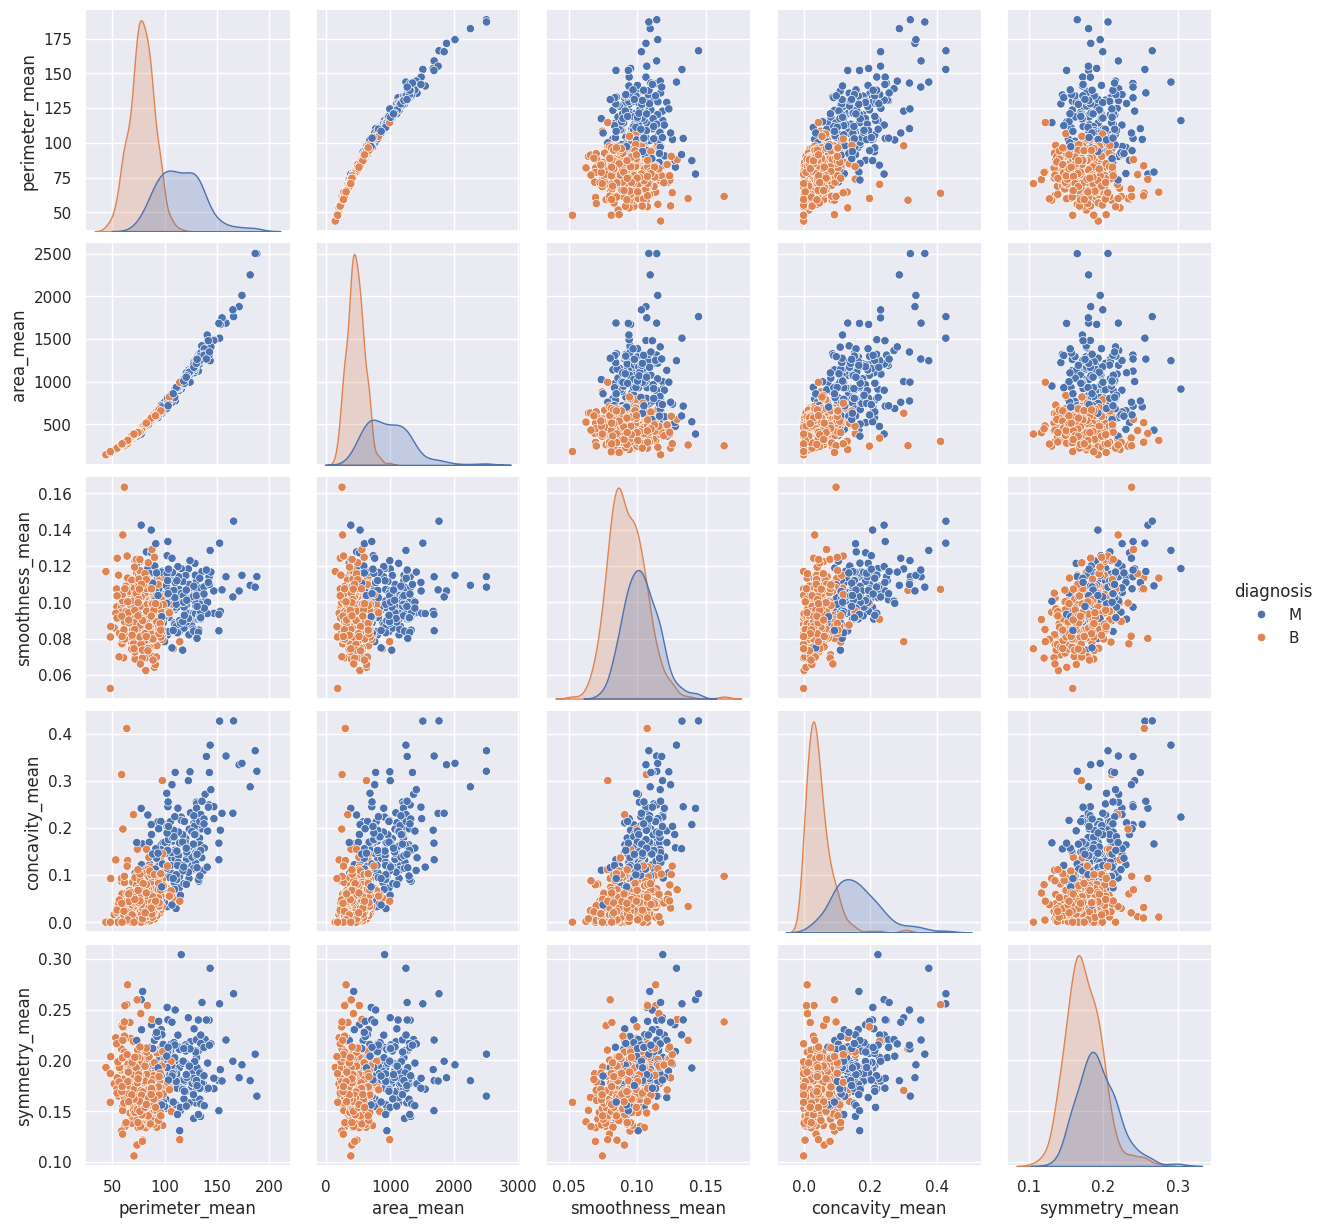

In [3]:
# Librerias para graficar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Graficamos algunas variables de a pares, distinguiendo entre diagnostico
sns.set()
sns.plotting_context("notebook", font_scale=1.2)
sns.pairplot(df,vars=['perimeter_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean'],hue="diagnosis")
plt.show()

Como sabemos, estos graficos nos muestran como se distribuye el atributo de diagnostico (benigno o maligno) entre cada par de variables seleccionadas. En la diagonal nos muestra la distribucion que tienen ambos valores de la variable diagnostico para una variable en particular. Algunas conclusiones de nuestro análisis preliminar podrían ser:
* ``area_mean`` y ``perimeter_mean`` tienen una clara correlación y determinan una separación abrupta. Cuando area_mean es mayor que aproximadamente 1,000, claramente el perimeter también aumenta, y el diagnóstico cambia de benigno a maligno de manera brusca. Por lo tanto, estos dos atributos son determinantes para el resultado final y es probable que uno de ellos sea redundante.

* Otras gráficas (por ejemplo, ``perimeter_mean``/``area_mean`` frente a ``smoothness_mean``, ``area_mean`` frente a ``symmetry_mean``, ``concavity_mean`` frente a ``smoothness_mean`` y ``concavity_mean`` frente a ``symmetry_mean``) muestran una separación horizontal (que se convierte en vertical al invertir el eje). Esto significa que, para casi todos los valores asumidos por la variable independiente (eje x), hay un umbral que separa los valores de la otra variable en dos conjuntos (benigno y maligno).

* Algunas gráficas (por ejemplo, ``perimeter_mean``/``area_mean`` frente a ``concavity_mean`` y ``concavity_mean`` frente a ``symmetry_mean``) muestran una ligera separación diagonal con pendiente negativa. Esto significa que cuando la variable independiente es pequeña, el diagnóstico permanece constante para casi todos los valores de la variable dependiente, mientras que, por otro lado, cuando la variable independiente se vuelve más grande, el diagnóstico cambia proporcionalmente al valor opuesto. Por ejemplo, para valores pequeños de ``perimeter_mean``, ``concavity_mean`` puede alcanzar su máximo sin afectar el diagnóstico (que es benigno), mientras que un ``perimeter_mean`` > 150 siempre resulta en un diagnóstico maligno independientemente de ``concavity_mean``.

Por supuesto, no podemos sacar fácilmente nuestras conclusiones de un análisis dividido (porque debemos considerar todas las interacciones), pero esta actividad será útil para proporcionar a cada grupo un etiquetado semántico

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE (t-distributed Stochastic Neighbor Embedding) es una técnica de reducción de dimensionalidad no lineal no supervisada utilizada para explorar datos y visualizar datos de alta dimensionalidad. La reducción de dimensionalidad no lineal significa que el algoritmo nos permite separar datos que no pueden ser separados por una línea recta. Específicamente, modela cada objeto de alta dimensionalidad mediante un punto de dos o tres dimensiones de tal manera que objetos similares se modelan mediante puntos cercanos y objetos disimilares se modelan mediante puntos distantes con alta probabilidad.

El algoritmo t-SNE consta de dos etapas principales. Primero, t-SNE construye una distribución de probabilidad sobre pares de objetos de alta dimensionalidad de tal manera que objetos similares tienen asignada una probabilidad más alta, mientras que los puntos disímiles tienen asignada una probabilidad más baja. Segundo, t-SNE define una distribución de probabilidad similar sobre los puntos en el mapa de baja dimensionalidad y minimiza la divergencia Kullback-Leibler (divergencia KL) entre las dos distribuciones con respecto a las ubicaciones de los puntos en el mapa. Si bien el algoritmo original utiliza la distancia euclidiana entre objetos como base de su métrica de similitud, esto se puede cambiar según sea necesario. Una variante riemanniana es UMAP.

t-SNE se ha utilizado para la visualización en una amplia gama de aplicaciones, incluyendo genómica, investigación en seguridad informática, procesamiento de lenguaje natural, análisis de música, investigación sobre el cáncer, bioinformática, interpretación de dominio geológico y procesamiento de señales biomédicas. Si bien las representaciones de t-SNE a menudo parecen mostrar grupos, los grupos visuales pueden estar fuertemente influenciados por la elección de la parametrización y, por lo tanto, es necesario comprender bien los parámetros de t-SNE. Estos "grupos" pueden incluso aparecer en datos no agrupados y, por lo tanto, pueden ser hallazgos falsos. La exploración interactiva puede ser necesaria para elegir parámetros y validar resultados. Se ha demostrado que t-SNE a menudo es capaz de recuperar grupos bien diferenciados y, con elecciones de parámetros especiales, se aproxima a una forma simple de agrupación espectral.

Para más detalles, consulte "Visualizing Data using t-SNE", van der Maaten L., Hinton G., Journal of Machine Learning Research 9, 2008.

## Visualizacion de Data con t-SNE

En este punto, es útil visualizar el conjunto de datos (sin los atributos no estructurales) en un plano bidimensional a través de una transformación de t-Distributed Stochastic Neighbor Embedding (t-SNE)




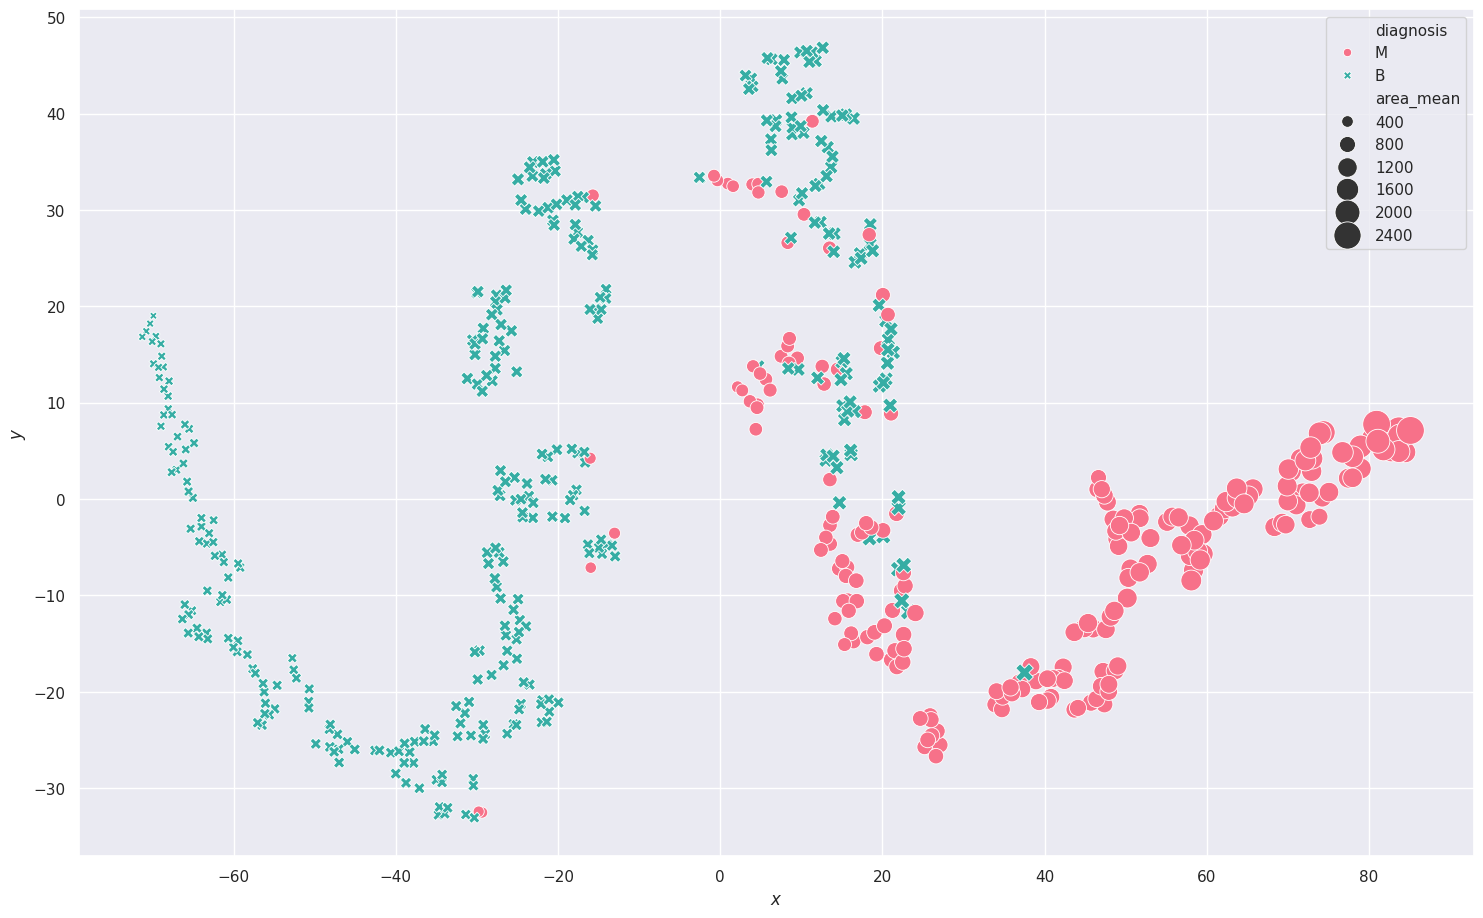

In [4]:
# Libreria t-SNE
from sklearn.manifold import TSNE

# Aplicamos metodo t-SNE
cdf = df.drop(['diagnosis'], axis=1)
tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(cdf)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=cdf.index)
dff = pd.concat([df, df_tsne], axis=1)

# Graficamos el resultado del proceso t-SNE
fig, ax = plt.subplots(figsize=(18, 11))
sns.plotting_context("notebook", font_scale=1.5)
sns.scatterplot(x='x',y='y',hue='diagnosis',size='area_mean',style='diagnosis',sizes=(30, 400),palette=sns.color_palette("husl", 2),data=dff,ax=ax)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

Un rápido análisis de la data nos puede hacer concluir que la mayoría de los datos pertenecientes a canceres malisnos se encuentran a la derecha de la recta $x=0$. Si bien algunos casos de cancer benigno nos pueden quedar a la derecha de dicha recta, debemos tener en cuenta que ninguna técnica de reducción de dimensionalidad nos dará la separación geométrica perfecta entre una cantidad de grupos $k$ (en este caso $k=2$).

## Aplicando K-Medias a la Data Reducida

En el siguiente código aplicaremos el algoritmo de K-medias a la data reducida en dimensionalidad producto de la técnica t-SNE.

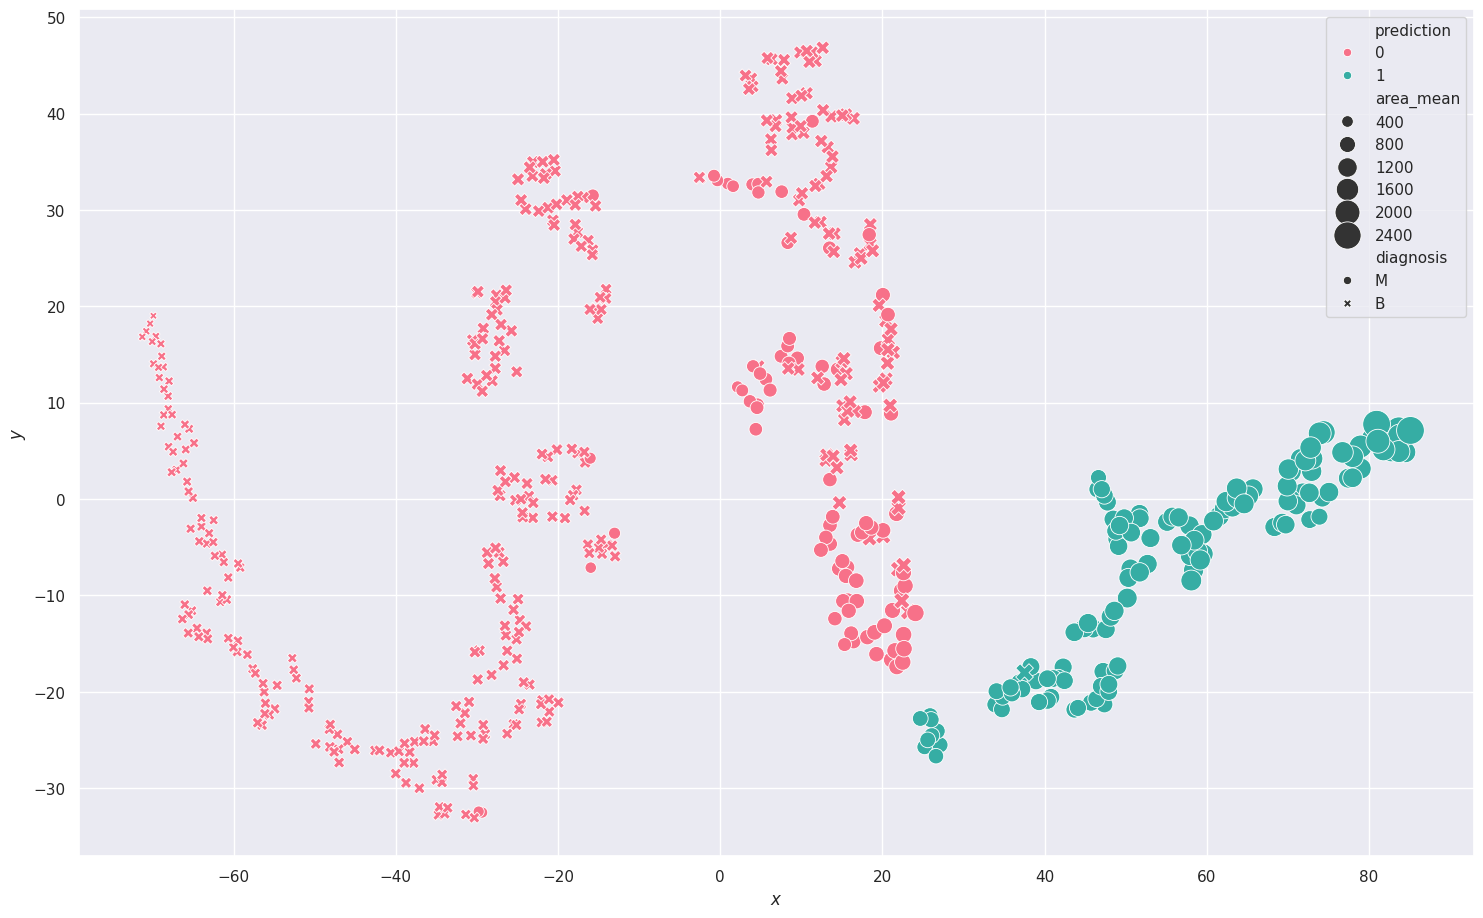

In [5]:
from sklearn.cluster import KMeans
# Establecemos una semilla para reproducibilidad
np.random.seed(1000)

# Ejecutamos algoritmo K-medias con K=2
km = KMeans(n_clusters=2, max_iter=1000, random_state=1000,n_init=10)
Y_pred = km.fit_predict(cdf)
df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
kmdff = pd.concat([dff, df_km], axis=1)

# Graficamos los resultados
fig, ax = plt.subplots(figsize=(18, 11))
sns.plotting_context("notebook", font_scale=1.5)
sns.scatterplot(x='x',y='y',hue='prediction',size='area_mean',style='diagnosis',sizes=(30, 400),palette=sns.color_palette("husl", 2),data=kmdff,ax=ax)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

Como era de esperar, el resultado es bastante preciso para $y < -20$, pero el algoritmo no logra incluir los puntos límite ($y ≈ 0$) en el grupo principal maligno. Esto se debe principalmente a la no convexidad de los conjuntos originales, y es muy difícil resolver el problema utilizando K-medias. Además, en la proyección, la mayoría de las muestras malignas con $y ≈ 0$ se mezclan con las benignas, por lo que la probabilidad de error también es alta con otros métodos basados en la proximidad. La única oportunidad de separar correctamente esas muestras se deriva de la distribución original. De hecho, si los puntos pertenecientes a la misma categoría pudieran ser capturados por conjuntos disjuntos en $\Re^{30}$, K-medias también podría tener éxito. Desafortunadamente, en este caso, el conjunto mezclado parece muy cohesionado, por lo que no podemos esperar mejorar el rendimiento sin una transformación. Sin embargo, para nuestros fines, este resultado nos permite aplicar las principales métricas de evaluación y luego pasar de $K=2$ a valores mayores. Con $K>2$, vamos a analizar algunos de los grupos, comparando su estructura con el gráfico de pares.

## Minimizar la Inercia

Uno de los mayores inconvenientes de K-medias y algoritmos similares es la solicitud explícita del número de agrupaciones. A veces, esta información está impuesta por restricciones externas (por ejemplo, en el caso de estudio, solo hay dos posibles diagnósticos), pero en muchos casos (cuando se necesita un análisis exploratorio), el científico de datos debe verificar diferentes configuraciones y evaluarlas. La forma más sencilla de evaluar el rendimiento de K-medias y elegir un número apropiado de grupos se basa en la comparación de diferentes inercias finales. Para explicar esto mediremos las inercias de un ejemplo generado a partir de 12 globos Gausianos muy compactos generados con la funcion de ```scikit-learn make_blobs()```

Comenzamos creando la data y mostrando resultados

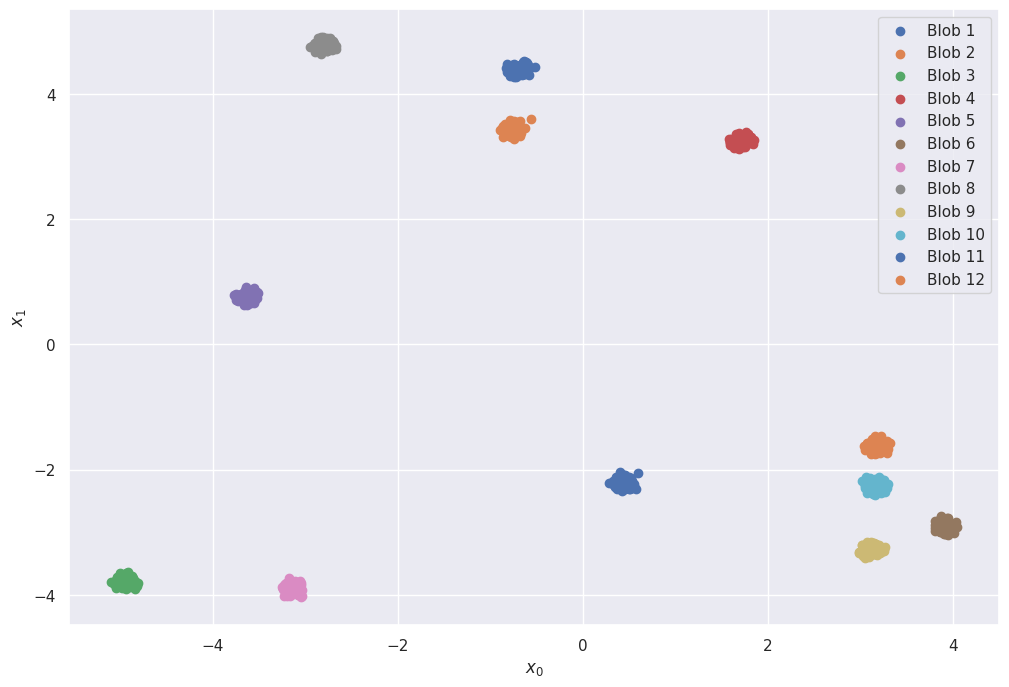

In [6]:
# Importa make_blobs y crea data
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=2000, n_features=2, centers=12,cluster_std=0.05, center_box=[-5, 5], random_state=100)

# Muestra la data
sns.set()
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(12):
    ax.scatter(X[Y == i, 0], X[Y == i, 1], label='Blob {}'.format(i + 1))
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.legend()
plt.show()

Ahora mostramos la grafica de la inercia para distintos números de agrupaciones y el código correspondiente.

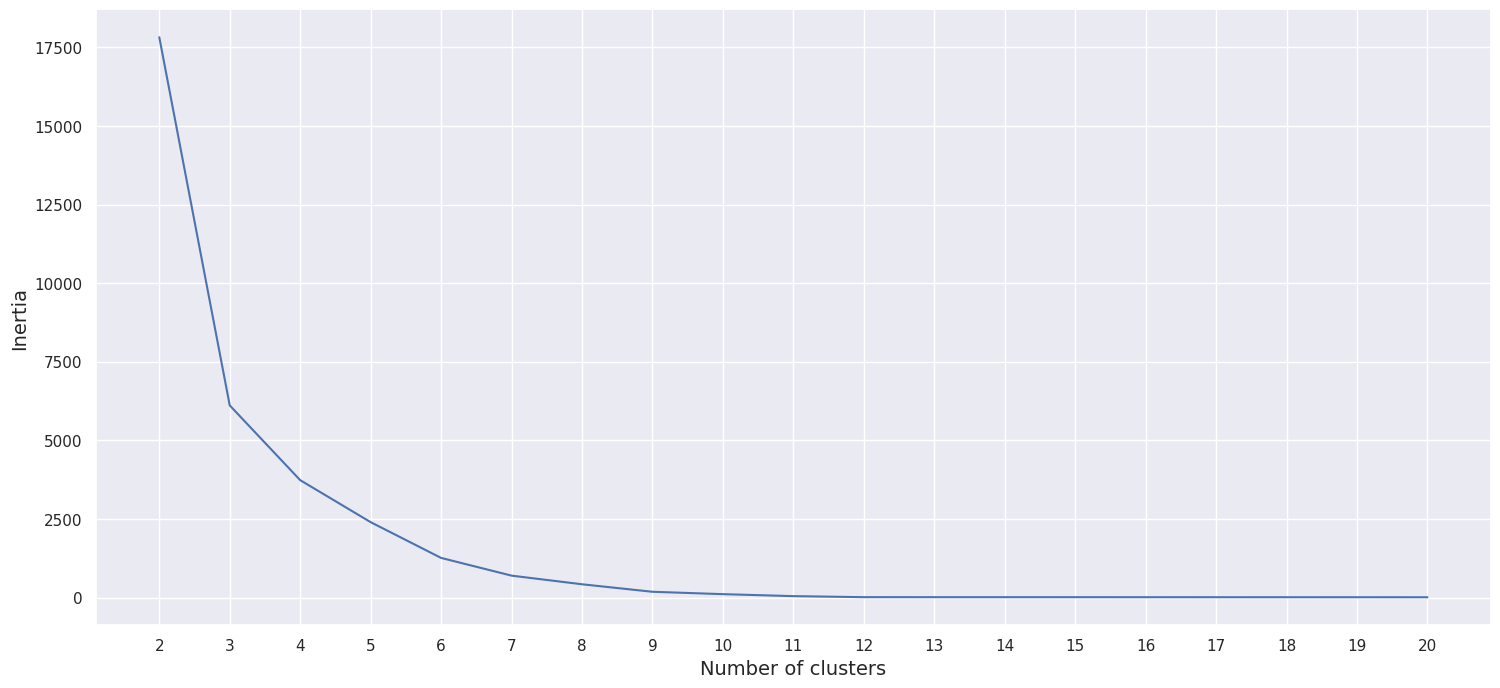

In [7]:
# Calculo de inercia
inertias = []
for i in range(2, 21):
    km = KMeans(n_clusters=i, max_iter=1000, random_state=1000,n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

# Grafica la inercia vs el numero de grupos
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(np.arange(2, 21, 1), inertias)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Inertia', fontsize=14)
ax.set_xticks(np.arange(2, 21, 1))
plt.show()

Algunos comentarios del proceso:
* El gráfico anterior muestra un comportamiento común. Cuando el número de grupos es muy pequeño, la densidad es proporcionalmente baja, por lo tanto, la cohesión es baja y, como resultado, la inercia es alta. Aumentar el número de grupos obliga al modelo a crear grupos más cohesionados y la inercia comienza a disminuir abruptamente.
* La regla heurística genérica (cuando no hay restricciones externas) es elegir el número de grupos correspondiente al punto que separa la región de alta variación de la casi plana, también conocida como técnica del codo (elbow criteria). La idea del "codo" es identificar el punto en el gráfico donde la disminución de la variabilidad comienza a aplanarse notablemente. Visualmente, este punto se parece a un codo en la gráfica. El punto de codo indica el número óptimo de clusters. Es el punto donde agregar un cluster adicional ya no proporciona mucha mejora en términos de reducción de variabilidad. Después de este punto, el beneficio de agregar más clusters se vuelve marginal en comparación con el costo computacional y la complejidad de interpretación.
* No obstante lo anterior, debemos tener cuidado al definir lo que entendemos por codo o punto en donde no existe valor agregado en incluir un grupo adicional. Para esto, es importante entender apropiadamente el contexto del problema con personas expertas en el negocio.
* Por supuesto, en este caso, si hubiéramos seleccionado K=15, nueve conjuntos habrían sido asignados a diferentes grupos, mientras que los otros tres se habrían dividido en dos partes. Obviamente, al dividir una región de alta densidad, la inercia sigue siendo baja, pero el principio de separación máxima ya no se sigue.

## Caso de Estudio: Minimizando la Inercia
Ahora revisaremos la inercia de nuestro caso de estudio para diferentes niveles de conglomerados (de 2 a 50)


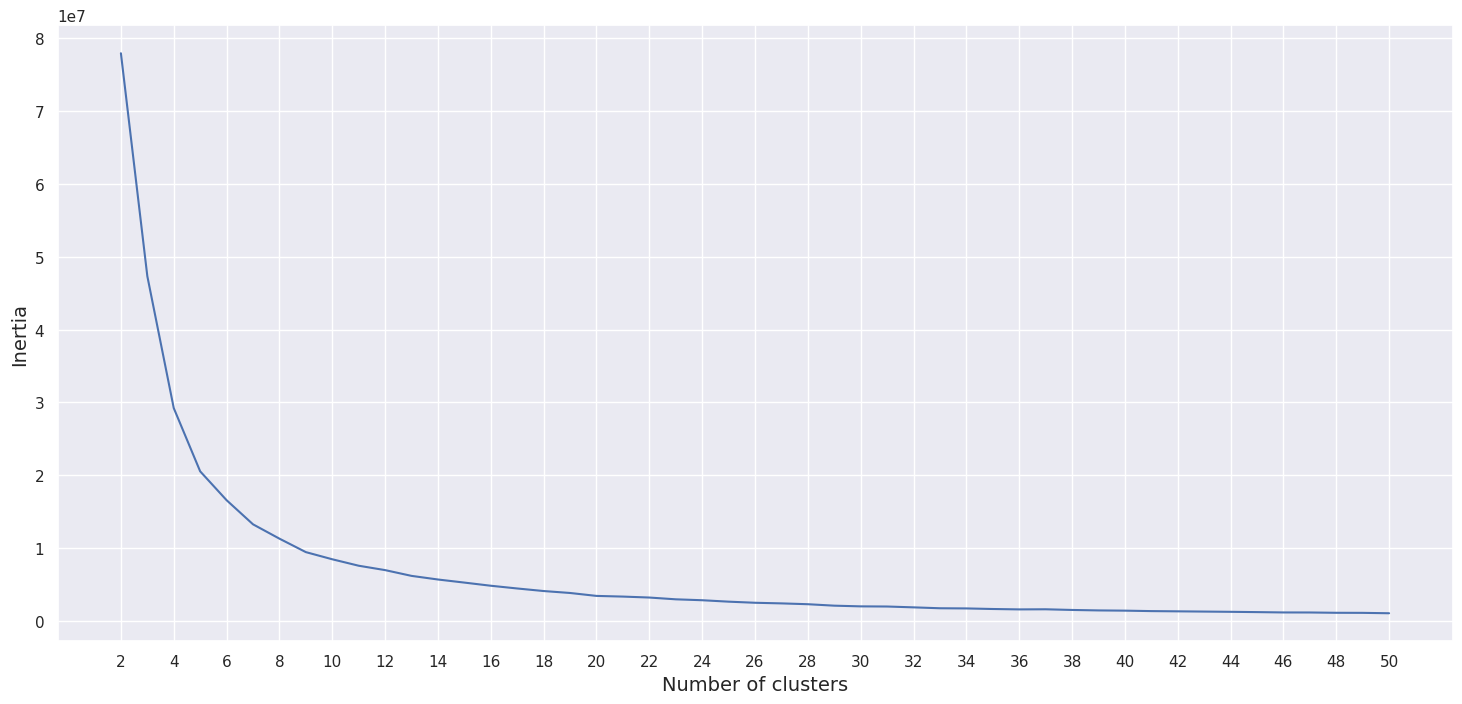

In [8]:
# Calculo de inercias
inertias = []
for i in range(2, 51):
    km = KMeans(n_clusters=i, max_iter=1000, random_state=1000, n_init=10)
    km.fit(cdf)
    inertias.append(km.inertia_)

# Grafica la inercia vs el numero de grupos
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(np.arange(2, 51, 1), inertias)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Inertia', fontsize=14)
ax.set_xticks(np.arange(2, 51, 2))
plt.show()

En este caso, la verdad fundamental sugiere que deberíamos agrupar en dos grupos correspondientes a los diagnósticos. Sin embargo, el gráfico muestra un descenso drástico que termina en K=8 y continúa con una pendiente más baja hasta aproximadamente K=40. Durante el análisis preliminar, hemos observado que la proyección bidimensional está compuesta por muchos conjuntos aislados que comparten el mismo diagnóstico. Por lo tanto, podríamos decidir emplear, por ejemplo, K=8 y analizar las características correspondientes a cada grupo. Dado que esto no es una tarea de clasificación, la verdad fundamental puede usarse como la principal referencia, pero un análisis exploratorio correcto puede intentar comprender la composición de las subestructuras para proporcionar detalles adicionales a los técnicos (por ejemplo, médicos). Ahora realizaremos un agrupamiento K-medias con ocho grupos en el conjunto de datos para describir la estructura de dos grupos de muestra, de la siguiente manera:

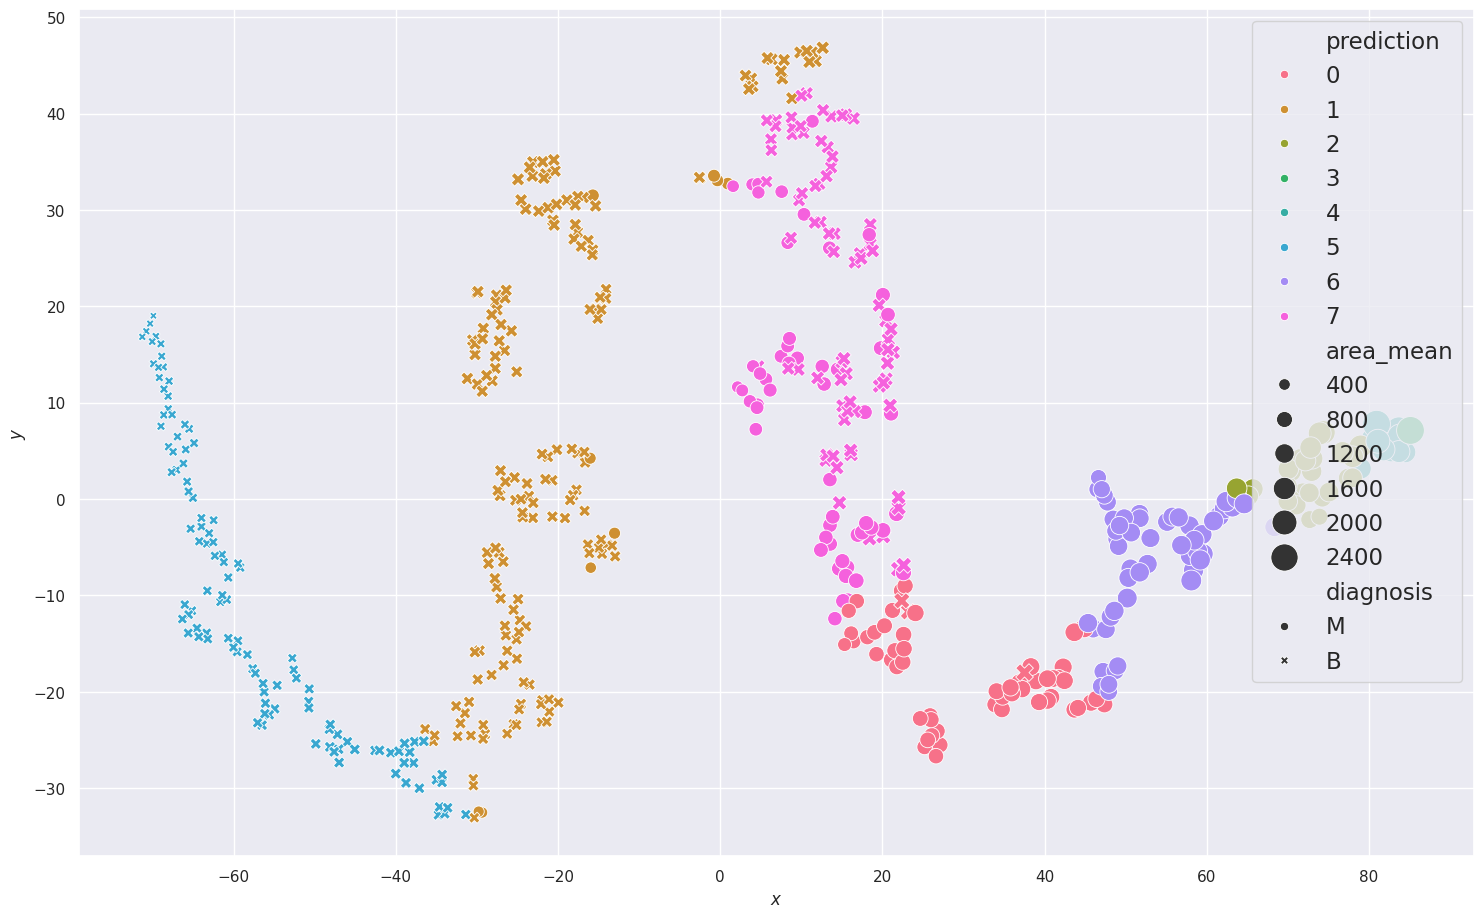

In [9]:
# Preparamos nuevamente la data del metodo t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(cdf)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=cdf.index)
dff = pd.concat([df, df_tsne], axis=1)

# Aplicamos algoritmo de k-medias con 8 grupos
km = KMeans(n_clusters=8, max_iter=1000, random_state=1000, n_init=10)
Y_pred = km.fit_predict(cdf)
df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
kmdff = pd.concat([dff, df_km], axis=1)

# Graficamos resultados
fig, ax = plt.subplots(figsize=(18, 11))
with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='x',y='y',hue='prediction',size='area_mean',style='diagnosis',sizes=(30, 400),palette=sns.color_palette("husl", 8),data=kmdff,ax=ax)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

Ahora, consideremos el intervalo $-25 < x < 30$ y $-60 < y <-40$ y revisemos estadística descriptiva sencilla de algunos de sus atributos.

In [13]:
sdff_1 = dff[(dff.x > -25.0) & (dff.x < 30.0) & (dff.y > -60.0) & (dff.y < -40.0)]
print(sdff_1[['perimeter_mean', 'area_mean', 'smoothness_mean','concavity_mean', 'symmetry_mean']].describe())

       perimeter_mean  area_mean  smoothness_mean  concavity_mean  \
count             0.0        0.0              0.0             0.0   
mean              NaN        NaN              NaN             NaN   
std               NaN        NaN              NaN             NaN   
min               NaN        NaN              NaN             NaN   
25%               NaN        NaN              NaN             NaN   
50%               NaN        NaN              NaN             NaN   
75%               NaN        NaN              NaN             NaN   
max               NaN        NaN              NaN             NaN   

       symmetry_mean  
count            0.0  
mean             NaN  
std              NaN  
min              NaN  
25%              NaN  
50%              NaN  
75%              NaN  
max              NaN  


Desde la verdad fundamental, sabemos que todas estas muestras son malignas, pero podemos intentar determinar una regla. La relación entre el área media y el perímetro medio es aproximadamente de 9.23 y las desviaciones estándar relativas son muy pequeñas en comparación con las medias. Esto significa que estas muestras representan tumores extendidos en un rango muy estrecho. Además, tanto la concavidad media como la simetría media son mayores que los valores generales. Por lo tanto (sin la presunción de un análisis científicamente razonable), podemos concluir que las muestras asignadas a estos grupos representan tumores muy graves que han alcanzado una etapa avanzada. Ahora revisemos la siguiente área $x> -10$ y $ 20 < y
< 50$

In [12]:
sdff_2 = dff[(dff.x > -10.0) & (dff.y > 20.0) & (dff.y < 50.0)]
print(sdff_2[['perimeter_mean', 'area_mean', 'smoothness_mean','concavity_mean', 'symmetry_mean']].describe())

       perimeter_mean   area_mean  smoothness_mean  concavity_mean  \
count       72.000000   72.000000        72.000000       72.000000   
mean        88.493472  575.712500         0.093084        0.066806   
std          3.461674   43.960347         0.014348        0.059568   
min         81.090000  475.900000         0.064290        0.002758   
25%         86.315000  554.425000         0.082568        0.023545   
50%         88.110000  575.300000         0.092455        0.045135   
75%         89.782500  599.650000         0.102300        0.097180   
max         97.830000  698.800000         0.127800        0.300300   

       symmetry_mean  
count      72.000000  
mean        0.171221  
std         0.023509  
min         0.134200  
25%         0.156025  
50%         0.170800  
75%         0.182850  
max         0.238400  


### Conclusiones del Ejercicio

En este caso, la relación entre el área media y el perímetro medio es aproximadamente de 4.89, pero el área media tiene una desviación estándar más grande (de hecho, su valor máximo es de alrededor de 410). La concavidad media es extremadamente pequeña en comparación con la anterior (incluso con aproximadamente la misma desviación estándar), mientras que la simetría media es casi equivalente. A partir de este breve análisis, podemos deducir que la simetría media no es una característica discriminante, mientras que una relación entre el área media y el perímetro medio menor que 5.42 (considerando los valores máximos) con una concavidad media menor o igual a 0.04 debería garantizar un resultado benigno. Dado que la concavidad media puede alcanzar un valor máximo muy grande (mayor que el asociado con muestras malignas), es necesario considerar también las otras características para decidir si su valor debe ser considerado como una alarma. Sin embargo, podemos concluir diciendo que todas las muestras pertenecientes a estos grupos son benignas con una probabilidad de error insignificante

Es importante recalcar que esto es más un ejercicio que un análisis real y, en tales situaciones, la tarea principal del científico de datos es recopilar piezas de información contextual que puedan respaldar las conclusiones. Incluso en presencia de la verdad fundamental, este proceso de validación es siempre obligatorio porque la complejidad de las causas subyacentes puede llevar a afirmaciones y reglas completamente erróneas

